# Learning curve

### import modules and configure notebook

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)
%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [2]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats


### configurations
* save_plots -> boolean
* random_seed_state -> number, sets random state for model and for stratified splits 
* pickle_model -> boolean, wether model should be serialised and saved
* pickle_model_name -> string, name of serialised model
* grid_search -> boolean, if set to true then grid search is performed to identify optimum hyperparamaters for model 
* scale -> boolean, if set to True then features scaled to all have mean value 0 and standard deviation 1
* pickle_file_path -> string, filepath for serialised model to be saved to

In [56]:
save_plots = True
random_seed_state = 42
pickle_model = False
pickle_model_name = 'grouped'
pickle_file_path = '../../../model'
grid_search = False
scale = False

### counts of instances in all classes before oversampling

In [4]:
train_data_formodel['class'].value_counts()

19    148
4     135
21    105
15    100
20     74
16     61
22     60
0      53
9      47
11     45
14     36
13     36
12     36
2      36
10     30
7      30
6      30
8      27
5      27
18     27
1      24
17     18
3      18
Name: class, dtype: int64

### The class column is stored as the variable y 

In [5]:
y = np.array(train_data_formodel['class'])

### The variables identified as best by the 2 feature_selection notebook are used as features

In [6]:
train_data_feats = train_data_formodel[best_feats]

In [7]:
X = np.array(train_data_feats)

### Define function for plotting learning curve

In [20]:
def learningCurve(model, X, y, cv, train_sizes = np.linspace(0.1, 1.0, 20)):
    
    train_sizes, train_scores, test_scores = learning_curve(model, X = X, y = y, cv=cv, n_jobs=-1, train_sizes= train_sizes, shuffle = True, scoring = 'f1_weighted', verbose = 2)
    
    train_scores_flat = []
    for i in train_scores:
        for i_2 in i:
            train_scores_flat.append(i_2)
            
    test_scores_flat = []
    for i in test_scores:
        for i_2 in i:
            test_scores_flat.append(i_2)
            
    train_sizes_duped = []
    for i in train_sizes:
        for i_2 in range(0, cv):
            train_sizes_duped.append(i)
            
    df = pd.DataFrame(data = {'train_sizes':train_sizes_duped, 'train_score':train_scores_flat, 'test_scores':test_scores_flat})
    
    df_melt = pd.melt(df, id_vars=['train_sizes'], value_vars=['train_score', 'test_scores'], var_name='train_or_test_data', value_name='k_fold_stratified_scores')
    
    df_melt.sort_values(by = 'train_sizes', ascending=True, inplace=True)
    
    return(df_melt)



### call function for plotting learning curve 

In [21]:
rfc_lc = learningCurve(RandomForestClassifier(n_estimators=1700, random_state = random_seed_state, n_jobs=-1, 
                              min_samples_split =  3, min_samples_leaf = 1, max_features = 'auto', 
                              max_depth = 100, bootstrap =  True), X, y, cv = 5, train_sizes = np.linspace(0.1, 1.0, 20))

[learning_curve] Training set sizes: [ 95 140 185 230 276 321 366 411 456 502 547 592 637 682 728 773 818 863
 908 954]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.

### visualise learning curve for Random Forest Classifier

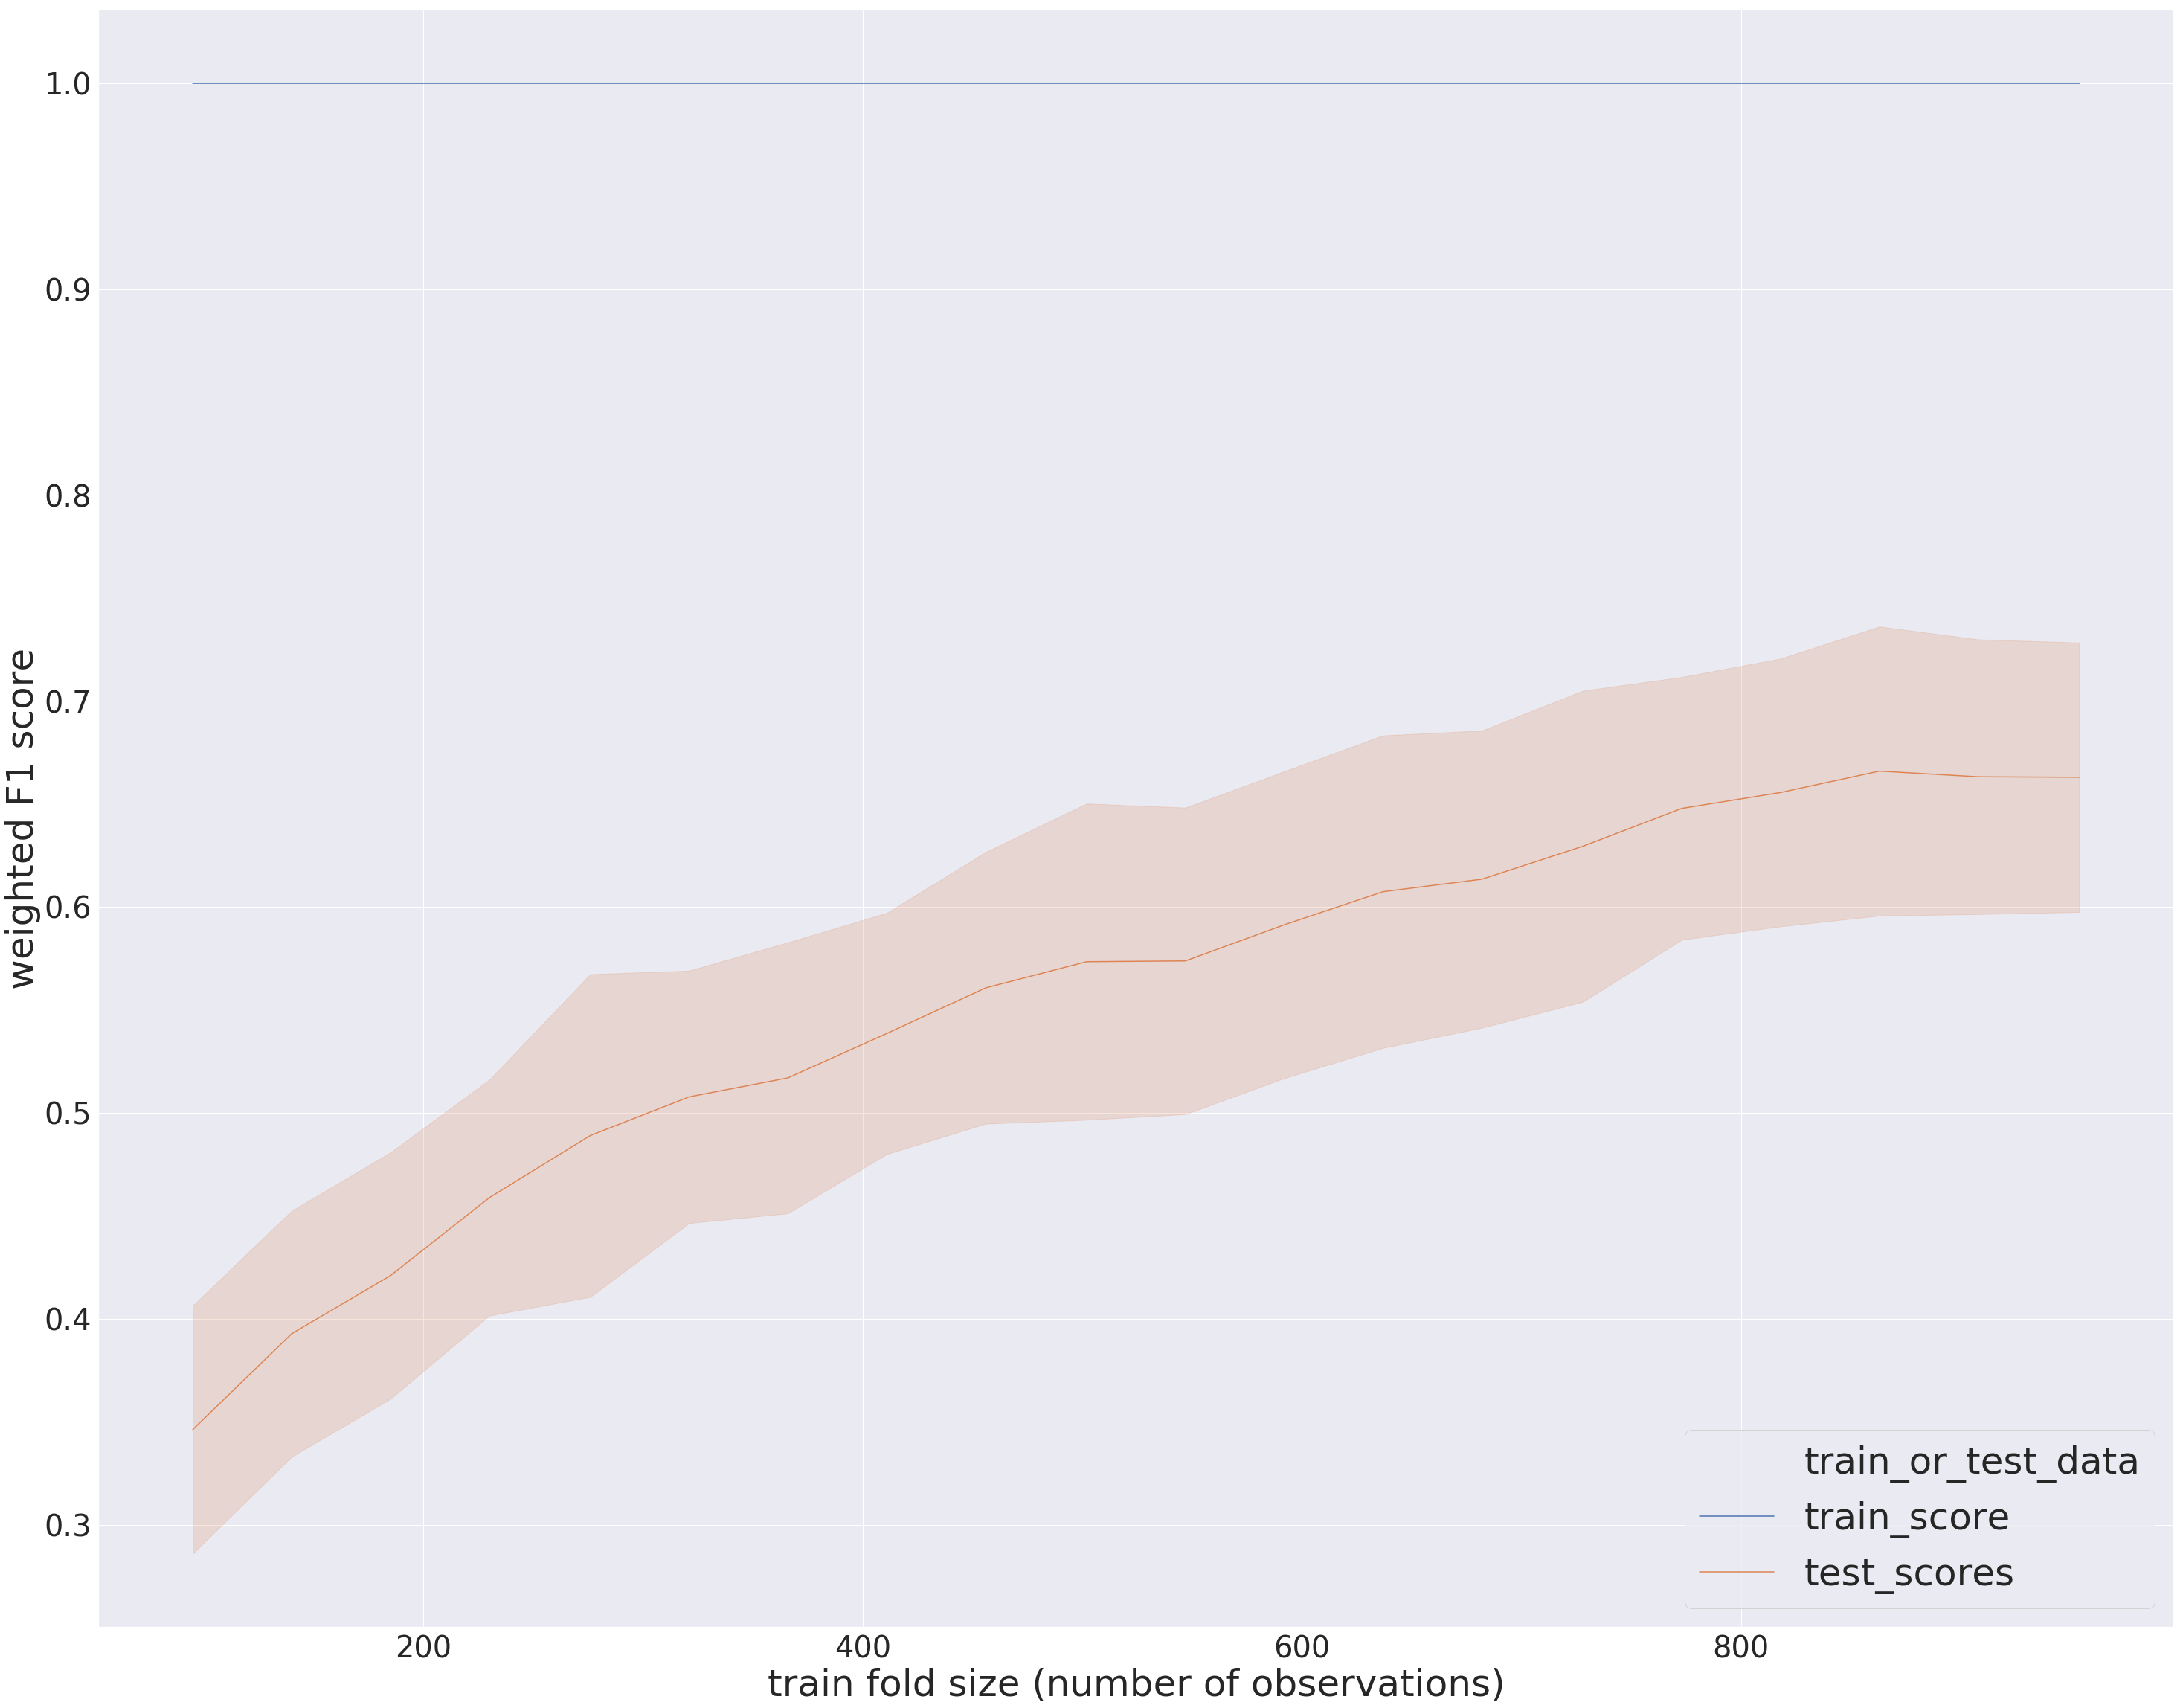

In [58]:
sns.set(rc={'figure.figsize':(50,40)})
plot = sns.lineplot(x = 'train_sizes', y = 'k_fold_stratified_scores', hue = 'train_or_test_data' ,data = rfc_lc, ci = 'sd', markers = "o")
plot.set_xlabel("train fold size (number of observations)",fontsize=50)
plot.set_ylabel("weighted F1 score",fontsize=50)
plot.set_xlabel("train fold size (number of observations)",fontsize=50)
plot.tick_params(labelsize=40)

plt.legend(fontsize = 50, loc = 4)

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('figures/training_curve.png')
